In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from numba import njit
%matplotlib widget

In [16]:
# @njit
# def W(r, h):
#     """Wendland C4 kernel, 1D."""
#     q = np.abs(r)/h
#     coef = 3/(4*h)
#     return np.where(q <= 2, coef * (1-q/2)**5 * (2*q**2 + 5/2*q + 1), 0.0)

# @njit
# def dW(r, h):
#     """Derivative of Wendland C4 kernel, 1D."""
#     q = np.abs(r)/h
#     coef = 3/(4*h**2)
#     sign = np.sign(r)
#     return sign * np.where(q < 2, coef * -7*q*(1-q/2)**4 * (q+1/2), 0.0)
# Wendland C2 kernel and its derivative, 1D version
@njit
def W(r, h):
    q = np.abs(r)/h
    coef = 5/(8*h) # Normalization constant for 1D
    return np.where(q <= 2, coef * (1-q/2)**3 * (1.5*q + 1), 0.0)

@njit
def dW(r, h):
    q = np.abs(r)/h
    coef = 5/(8*h**2) # Normalization constant for 1D
    sign = np.sign(r)
    return sign * np.where(q < 2, coef * -3*q*(1-q/2)**2, 0.0)

In [17]:

def get_nearest_neighbors(points, k=8, boxsize=None):
    """
    Finds the k nearest neighbors for each point in a point set using scipy.spatial.cKDTree.

    Parameters:
    ----------
    points : ndarray of shape (N, D)
        The input array of N points in D-dimensional space.
    k : int
        The number of nearest neighbors to find

    Returns:
    -------
    neighbors_indices : ndarray of shape (N, k)
        Indices of the k nearest neighbors for each point, incl. self
    neighbors_distances : ndarray of shape (N, k)
        Distances to the k nearest neighbors for each point, incl. self
    """
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    tree = KDTree(data=points, boxsize=boxsize)
    distances, indices = tree.query(x=points, k=k)

    return indices, distances

In [73]:
@njit
def get_hydro_interaction( X, idx, dist, m, V, u, gamma, dtmax, CFLfac, Nngb, boxsize, Nngbmin = 4 ):
  """
  Compute hydrodynamic interactions for SPH particles.

  Parameters:
    X (ndarray):    Particle positions.
    idx (ndarray):  Indices of nearest neighbors for each particle.
    dist (ndarray): Distances to nearest neighbors for each particle.
    m (ndarray):    Particle masses.
    V (ndarray):    Particle velocities.
    u (ndarray):    Particle internal energies.
    gamma (float):  Adiabatic index.
    dtmax (float):  Maximum allowed timestep.
    CFLfac (float): CFL safety factor.
    Nngb (int):     Number of neighbors.
    boxsize (float):Sice of the periodic box (positions will be wrapped)
    Nngbmin (int):  Minimum number of neighbours.

  Returns:
    dV (ndarray):   Accelerations for each particle.
    de (ndarray):   Rate of change of internal energy for each particle.
    dt (float):     Timestep.
    rho (ndarray):  Densities for each particle.
  """
  N = X.shape[0]
  l2 = boxsize/2
  l  = boxsize
  def wrap(x, y):
      d = x - y
      # Handle both scalar and array input for periodic boundary conditions
      d = np.asarray(d)
      d = np.where(d > l2, d - l, d)
      d = np.where(d < -l2, d + l, d)
      return d

  hi = dist[:,Nngb-1]/2  # starting guess for smoothing: distance to Nngb-th neighbour
  himin = dist[:,Nngbmin-1]/2    # minimum smoothing length: distance to Nngbmin-th-neighbour

  # Iteratively solve for consistent density and smoothing length
  rho = np.zeros(N)
  rho_old = np.ones(N) * 1e10  # Initialize with large value for convergence check
  h_factor = 1.2 
  max_iterations = 5
  tolerance = 1e-3

  # Iterate until convergence
  for iteration in range(max_iterations):
      # Compute density with current smoothing lengths
      rho = np.zeros(N)
      for i in range(N):
          interact = idx[i,:]
          hij = 0.5*(hi[i] + hi[interact])
          rij = wrap( X[i], X[interact])
          rho[i] = np.sum(m[interact] * W(rij, hij))
      
      # Check convergence
      if np.max(np.abs(rho - rho_old)/rho) < tolerance:
          break
          
      # Store current density for next iteration
      rho_old = rho.copy()
      
      # Update smoothing lengths
      for i in range(N):
          h_new = h_factor * (m[i]/rho[i])**(1.0/1.0)  # 1D: h ∝ m^(1/d)/ρ^(1/d)
          # Relaxation factor to prevent oscillations
          h_new = 0.7 * hi[i] + 0.3 * h_new
          # Minimum/maximum bound on smoothing length
          hi[i] = min(max(h_new,himin[i]),hi[i]) 
          # hi[i] = min(max(h_new, himin[i]), himax[i]) 

  # Ensure density is positive
  rho = np.maximum(rho, 1e-5)  # Avoid division by zero

  # Compute pressure and sound speed
  P = (gamma - 1) * rho * u
  c = np.sqrt(gamma * P / rho)
  
  # Time step
  dt = CFLfac * np.min(hi / (np.abs(V) + c + 1e-5))
  dt = min( dt, dtmax )

  # Compute acceleration and du/dt
  dV = np.zeros(N)
  de = np.zeros(N)
  for i in range(N):
    # Compute density gradient factor (needed for correction terms)
    sum_term = 0.0
    for j in idx[i,1:Nngb]:
      hij = 0.5 * (hi[i] + hi[j])
      rij = wrap(X[i], X[j])
      sum_term -= m[j] * rij * dW(rij, hij) / rho[j]
    
    # Dimensionality factor (1 for 1D)
    omega = 1.0 + (hi[i]/1.0) * sum_term

    for j in idx[i,1:Nngb]: # exclude self
      hij = 0.5 * (hi[i] + hi[j])
      vij = V[i] - V[j]
      rij = wrap(X[i], X[j])
      wij = dW(rij, hij)

      # Lattanzio et al. 1985 viscosity
      pi_ij = 0.0
      mu_ij = hij * vij * rij / (rij**2 + 0.01 * hij**2)
      if vij * rij < 0:
          alpha = 1.0  # Viscosity parameter
          beta  = 2.0   # Second viscosity parameter
          pi_ij = (-alpha * mu_ij * (c[i] + c[j])/2 + beta * mu_ij**2) / ((rho[i] + rho[j])/2)
          
      ## uncomment for different flavours of SPH
      # Monaghan & Gingold SPH 
      # dV[i] -= m[j] * (P[i]/rho[i]**2 + P[j]/rho[j]**2 + pi_ij) * wij / omega
      # de[i] += 0.5 * m[j] * (P[i]/rho[i]**2 + P[j]/rho[j]**2 + pi_ij) * vij * wij / omega

      # Hernquist & Katz SPH
      # dV[i] -= m[j] * (2*np.sqrt(P[j]*P[i])/rho[j]/rho[i] + pi_ij) * wij / omega
      # de[i] += 0.5 * m[j] * (2*np.sqrt(P[j]*P[i])/rho[j]/rho[i] + pi_ij) * vij * wij / omega

      # Saitoh & Makino SPH
      dV[i] -= m[j] * ((P[i]+P[j])/(rho[i]*rho[j]) + pi_ij) * wij  / omega
      de[i] += 0.5 * m[j] * ((P[i]+P[j])/(rho[i]*rho[j]) + pi_ij) * vij * wij / omega

  return dV, de, dt, rho

In [74]:
# time step function wrapper
def get_hydro_update( X, m, V, u, gamma, dtmax, CFLfac = 0.9, Nngb=8, boxsize=None, adapt_smoothing_iteratively=True ):

  # determine distances and interaction lists
  idx, dist = get_nearest_neighbors( X[:,np.newaxis], Nngb+2, boxsize )
  
  # call numba njitted interaction calculation (cannot include NN determination)
  return get_hydro_interaction( X, idx, dist, m, V, u, gamma, dtmax, 
                               CFLfac, Nngb, boxsize, adapt_smoothing_iteratively )

In [75]:
def SPH_step_KDK( X, m, V, u, gamma, dtmax, CFLfac = 0.9, Nngb=8, boxsize=None ):
  """
  Leapfrog KDK (Kick-Drift-Kick) time integration step for SPH.

  Args:
    X (np.ndarray): Particle positions.
    m (np.ndarray): Particle masses.
    V (np.ndarray): Particle velocities.
    u (np.ndarray): Particle internal energies.
    gamma (float): Adiabatic index.
    dtmax (float): Maximum allowed timestep.
    CFLfac (float): CFL safety factor.
    Nngb (int): Number of neighbors.

  Returns:
    dt (float): Timestep proposed.
    X (np.ndarray): Updated positions.
    V (np.ndarray): Updated velocities.
    u (np.ndarray): Updated internal energies.
    rho (np.ndarray): Updated densities.
  """
  
  # select active set of particles that receive an update
  active = X < np.inf #np.logical_and(X < 0.05, X < 0.95)

  # kick leapfrog update, determine timestep
  dV, de, dt, rho = get_hydro_update( X, m, V, u, gamma, dtmax, CFLfac=CFLfac, Nngb=Nngb, boxsize=boxsize )
  V[active] += dt/2 * dV[active]
  u[active] += dt/2 * de[active]
  u = np.maximum( u, 1e-6 )

  # drift leapfrog update
  X[active] = np.mod( boxsize + X[active] + dt * V[active], boxsize )

  # kick leapfrog update
  dV, de, _, rho = get_hydro_update( X, m, V, u, gamma, dtmax, CFLfac=CFLfac, Nngb=Nngb, boxsize=boxsize )
  V[active] += dt/2 * dV[active]
  u[active] += dt/2 * de[active]
  u = np.maximum( u, 1e-6 )

  return dt, X, V, u, rho


In [80]:
####### MAIN SIMULATION SETUP ##################################
# Parameters, box is periodic, we solve the problem twice and
# plot only the first copy, i.e. solve [L R R L], plot [L R]
N = 128                    # Number of particles
Lbox = 2.0
X = np.linspace(0, Lbox, 2*N,endpoint=False)   # Domain
dx = X[1] - X[0]
gamma = 5/3                 # Adiabatic index
CFL = 0.9

# Initial conditions
rho_L = 1.0
rho_R = 1.0
v_L = 0.0
v_R = 0.0
P_L = 1000.0
P_R = 0.01
t_end = 0.008

rho = np.where((X < 0.5) | (X>1.5), rho_L, rho_R )
P   = np.where((X < 0.5) | (X>1.5), P_L, P_R )
V   = np.where((X < 0.5) | (X>1.5), v_L, v_R )

u = P / ((gamma - 1) * rho)
m = rho * dx  

In [81]:
###### MAIN TIME INTEGRATION LOOP ##############################
t = 0.0
istep = 0
while t<t_end:
  dtmax = t_end-t
  dt, X, V, u, rho = SPH_step_KDK( X, m, V, u, gamma, dtmax, CFLfac = CFL, Nngb=8, boxsize=Lbox )
  
  P = (gamma - 1) * rho * u
  t += dt
  istep = istep+1
  print(f't = {t:.4f}, step = {istep}', end='\r')

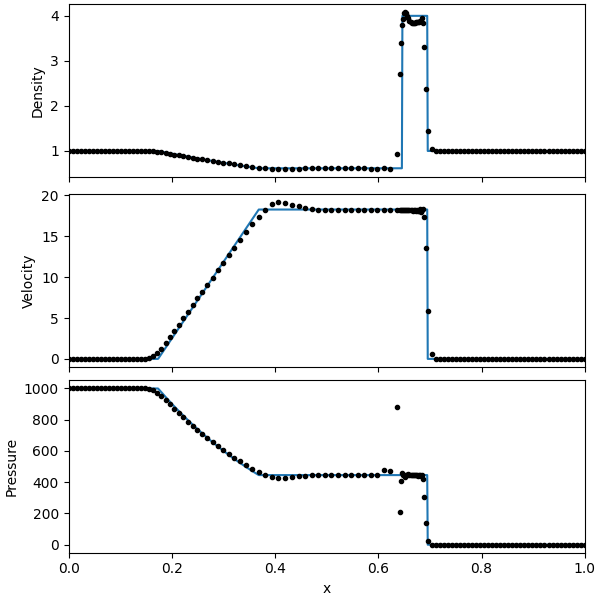

In [82]:
import riemann_exact as riemann

sol = riemann.solve_riemann_exact( left_state=(rho_L, v_L, P_L), right_state=(rho_R, v_R, P_R), gamma=gamma, t=t_end, npts = 1000)

# Plot results
fig, ax = plt.subplots(3,1,figsize=(6,6), sharex=True, layout='constrained')

ax[0].plot(sol['x'], sol['rho'], '-', label='$\\rho$ (exact)')
ax[0].plot(X, rho, 'k.')
ax[0].set_ylabel('Density')


ax[1].plot(sol['x'], sol['v'], '-', label='$\\rho$ (exact)')
ax[1].plot(X, abs(V), 'k.')
ax[1].set_ylabel('Velocity')


ax[2].plot(sol['x'], sol['P'], '-', label='$\\rho$ (exact)')
ax[2].plot(X, P, 'k.')
ax[2].set_ylabel('Pressure')
ax[2].set_xlabel('x')

for a in ax: a.set_xlim(0,1)